# Artificial Neural Networks and Deep Learning - Homework 2


## ⚙️ Import Libraries

In [1]:
!pip install focal-loss # default Keras focal loss does not support class weights 

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

import focal_loss

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 14
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load and prepare the Data

In [3]:
data = np.load("/kaggle/input/homework2/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
# Remove outliers (containing aliens)
outliers = [
    62,
    79,
    125,
    139,
    142,
    147,
    152,
    156,
    170,
    210,
    217,
    266,
    289,
    299,
    313,
    339,
    348,
    365,
    412,
    417,
    426,
    450,
    461,
    536,
    552,
    669,
    675,
    741,
    744,
    747,
    799,
    802,
    808,
    820,
    821,
    849,
    863,
    890,
    909,
    942,
    971,
    1005,
    1057,
    1079,
    1082,
    1092,
    1095,
    1106,
    1119,
    1125,
    1177,
    1194,
    1224,
    1247,
    1248,
    1258,
    1261,
    1262,
    1306,
    1324,
    1365,
    1370,
    1443,
    1449,
    1508,
    1509,
    1519,
    1551,
    1584,
    1588,
    1628,
    1637,
    1693,
    1736,
    1767,
    1768,
    1782,
    1813,
    1816,
    1834,
    1889,
    1925,
    1942,
    1975,
    1979,
    2000,
    2002,
    2086,
    2096,
    2110,
    2111,
    2151,
    2161,
    2222,
    2235,
    2239,
    2242,
    2301,
    2307,
    2350,
    2361,
    2365,
    2372,
    2414,
    2453,
    2522,
    2535,
    2561,
    2609,
    2614,
]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [6]:
# Count the number of pixels with a given label
label_list, counts = np.unique(y_train, return_counts=True)
for label, count in zip(label_list, counts):
    print(f"Number of pixels with label {int(label)}: {count}")

Number of pixels with label 0: 4988826
Number of pixels with label 1: 6957538
Number of pixels with label 2: 4776810
Number of pixels with label 3: 3770823
Number of pixels with label 4: 26963


In [7]:
class_weights = [sum(counts) / counts[i] for i in range(num_classes)]
class_weights[0] = 0
print(class_weights)

[0, 2.9494571211828093, 4.295954831781042, 5.44203745442308, 761.0785150020398]


In [8]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 2087
Number of images containing label 1: 1281
Number of images containing label 2: 1160
Number of images containing label 3: 863
Number of images containing label 4: 63


In [9]:
# Since there are few images with label 4, stratify using the presence of label 4
stratify = []
for labels in y_train:
    label_list = np.unique(labels)
    if 4.0 in label_list:
        stratify.append(1)
    else:
        stratify.append(0)
stratify = np.array(stratify)

In [10]:
# Split into training and validation (90-10)
val_size = 0.1
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=val_size, stratify=stratify
)

In [11]:
# Check imbalance between training and validation
train_counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        train_counts[int(value)] += 1

val_counts = [0 for _ in range(num_classes)]
for labels in y_val:
    label_list = np.unique(labels)
    for value in label_list:
        val_counts[int(value)] += 1

ratios = [val_counts[i] / train_counts[i] / val_size for i in range(num_classes)]

for i in range(num_classes):
    print(
        f"Ratio of images containing a label in validation vs train compared to ideal split for label {i}: {ratios[i]}"
    )

Ratio of images containing a label in validation vs train compared to ideal split for label 0: 1.1128860489882852
Ratio of images containing a label in validation vs train compared to ideal split for label 1: 1.187772925764192
Ratio of images containing a label in validation vs train compared to ideal split for label 2: 1.1861137897782064
Ratio of images containing a label in validation vs train compared to ideal split for label 3: 1.1211340206185567
Ratio of images containing a label in validation vs train compared to ideal split for label 4: 1.0526315789473684


In [12]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label


@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    return image, label

In [14]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [15]:
batch_size = 16

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (16, 64, 128, 1)
Labels shape: (16, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


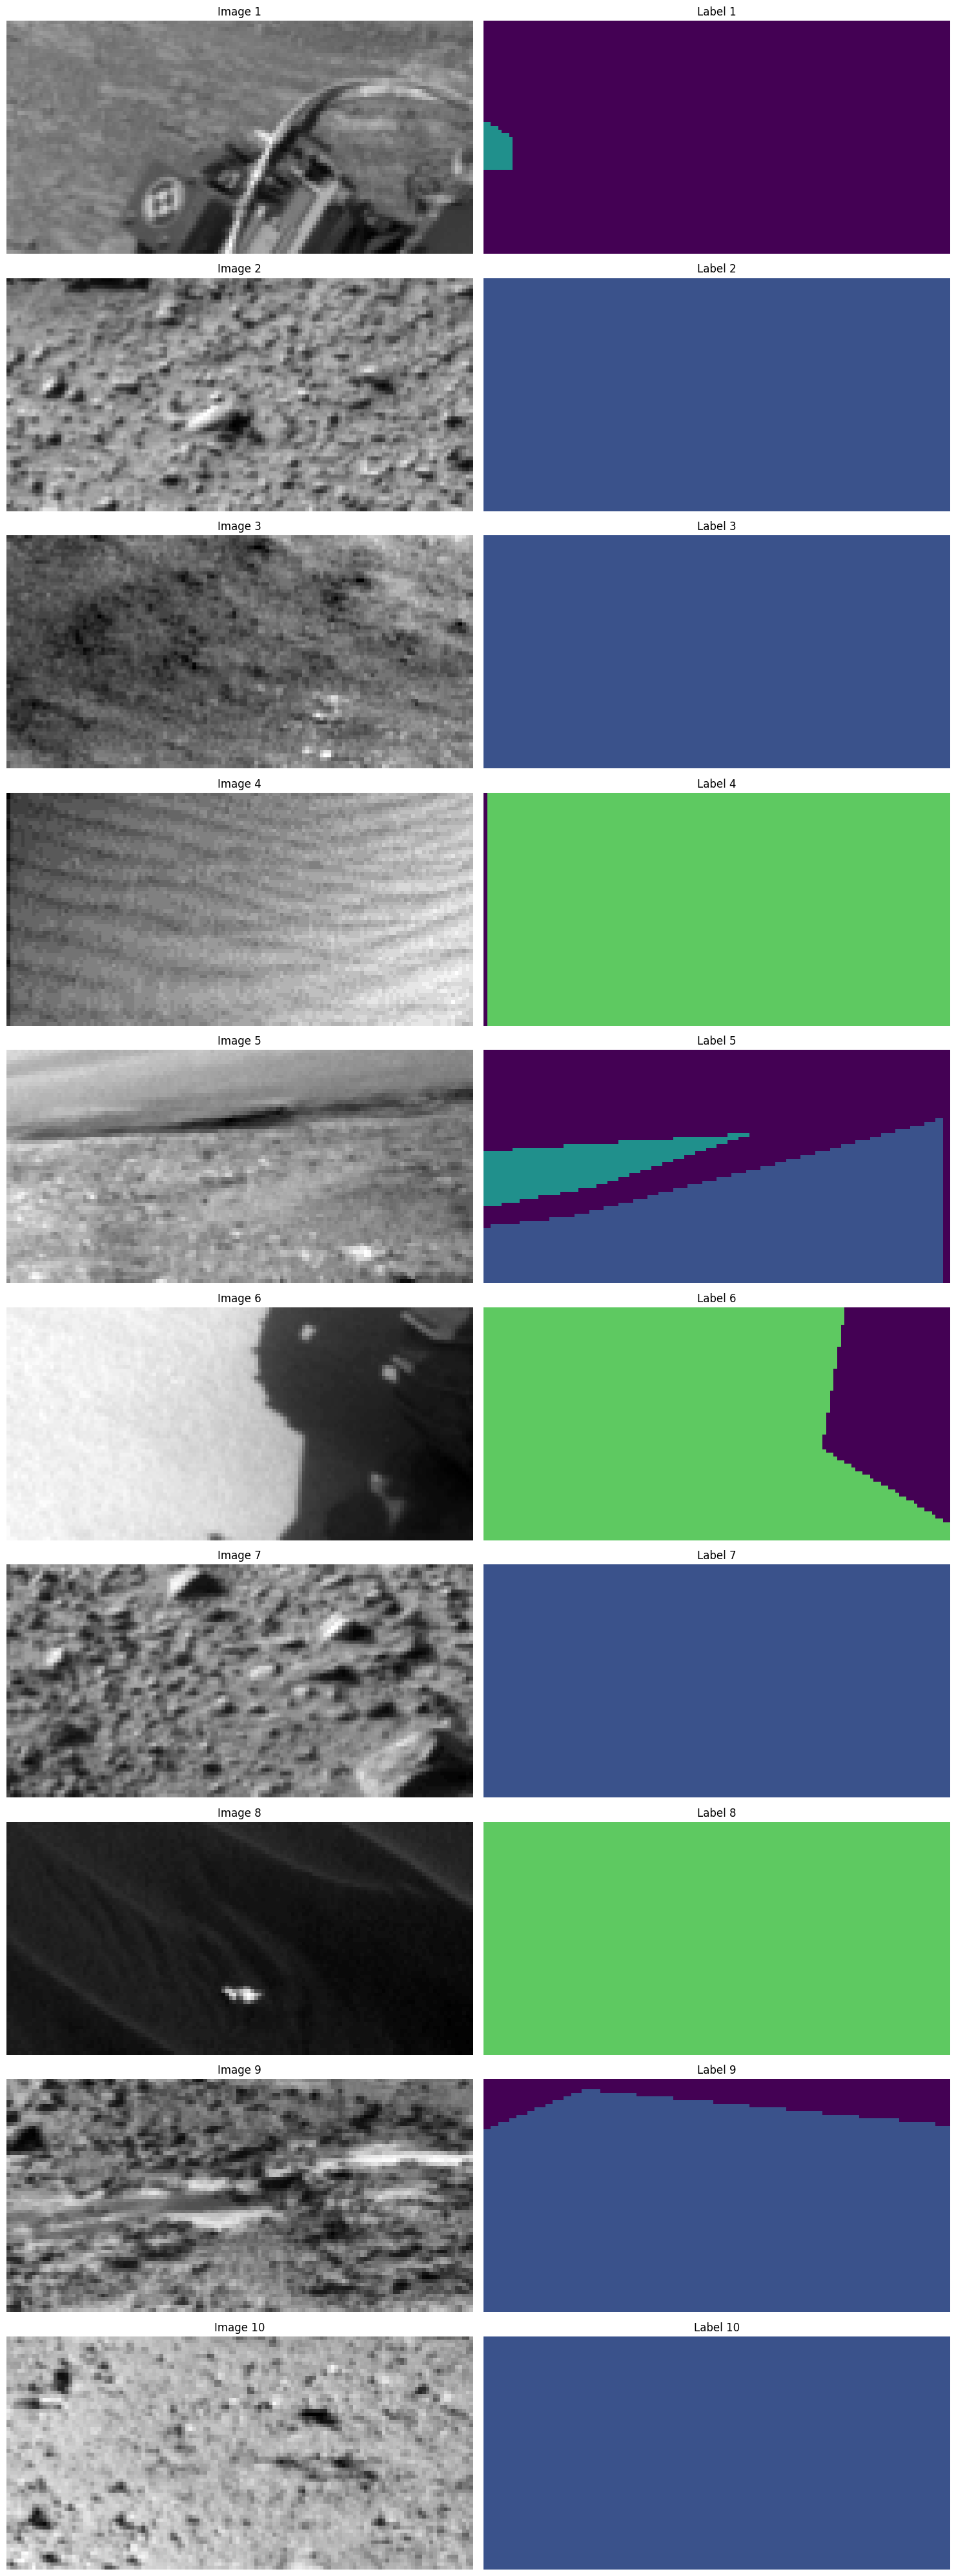

In [16]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="gray")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

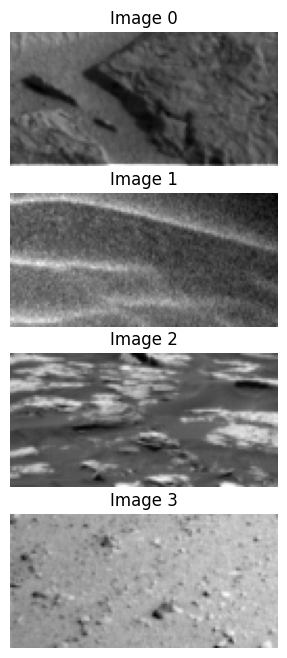

In [17]:
# Visualize examples from the test set
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="gray")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [18]:
def unet_block(
    input_tensor,
    filters,
    kernel_size=3,
    activation="relu",
    stack=1,
    name="",
    groups=8,
    dilation_rate=1,
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            dilation_rate=dilation_rate,
            kernel_regularizer=tfk.regularizers.L2(
                1e-3
            ),  # L2 regularization to reduce overfitting due to the large number of parameters
            name=name + "conv" + str(i + 1),
        )(x)
        # The layer is a GroupNormalization layer, or InstanceNormalization if groups=1
        # The "bn" in the layer's name is an oversight, as it used to be a BatchNormalization layer
        x = tfkl.GroupNormalization(name=name + "bn" + str(i + 1), groups=groups)(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [23]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")
    base_filters = 64

    # Downsampling path
    down_block_1 = unet_block(
        input_layer, base_filters, name="down_block1_", groups=1, stack=2
    )
    d1 = tfkl.SpatialDropout2D(0.05)(down_block_1)
    d1 = tfkl.MaxPooling2D()(d1)

    down_block_2 = unet_block(
        d1, base_filters * 2, name="down_block2_", groups=2, stack=2
    )
    d2 = tfkl.SpatialDropout2D(0.1)(down_block_2)
    d2 = tfkl.MaxPooling2D()(d2)

    down_block_3 = unet_block(
        d2, base_filters * 4, name="down_block3_", groups=4, stack=2
    )
    d3 = tfkl.SpatialDropout2D(0.15)(down_block_3)
    d3 = tfkl.MaxPooling2D()(d3)

    down_block_4 = unet_block(
        d3, base_filters * 8, name="down_block4_", groups=8, stack=2
    )
    d4 = tfkl.SpatialDropout2D(0.2)(down_block_4)
    d4 = tfkl.MaxPooling2D()(d4)

    down_block_5 = unet_block(
        d4, base_filters * 16, name="down_block5_", groups=8, stack=2
    )
    d5 = tfkl.SpatialDropout2D(0.25)(down_block_5)
    d5 = tfkl.MaxPooling2D()(d5)

    # Bottleneck
    bottleneck = unet_block(
        d5, base_filters * 32, name="bottleneck", groups=8, stack=2, dilation_rate=2
    )  # increasing group size due to increasing number of filters
    bottleneck = tfkl.SpatialDropout2D(0.3)(
        bottleneck
    )  # increasing dropout rates, as deeper levels seem to overfit more

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(
        base_filters * 16, kernel_size=2, strides=2, padding="same"
    )(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_5])
    u1 = unet_block(u1, base_filters * 16, name="up_block1_", groups=8, stack=2)

    u2 = tfkl.Conv2DTranspose(
        base_filters * 8, kernel_size=2, strides=2, padding="same"
    )(u1)
    u2 = tfkl.Concatenate()([u2, down_block_4])
    u2 = unet_block(u2, base_filters * 8, name="up_block2_", groups=8, stack=2)

    u3 = tfkl.Conv2DTranspose(
        base_filters * 4, kernel_size=2, strides=2, padding="same"
    )(u2)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, base_filters * 4, name="up_block3_", groups=4, stack=2)

    u4 = tfkl.Conv2DTranspose(
        base_filters * 2, kernel_size=2, strides=2, padding="same"
    )(u3)
    u4 = tfkl.Concatenate()([u4, down_block_2])
    u4 = unet_block(u4, base_filters * 2, name="up_block4_", groups=2, stack=2)

    u5 = tfkl.Conv2DTranspose(base_filters, kernel_size=2, strides=2, padding="same")(
        u4
    )
    u5 = tfkl.Concatenate()([u5, down_block_1])
    u5 = unet_block(u5, base_filters, name="up_block5_", groups=1, stack=2)

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="UNet")
    return model

In [24]:
# Define some hyperparameters
epochs = 1000
patience = 45
learning_rate = 1e-4

In [25]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
try:
    tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)
except:
    print("Model too complex to plot!")

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout2d │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│ (SpatialDropout2… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ spatial_dropo… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (GroupNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (GroupNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_dropout2… │ (None, 32, 64,  │         0 │ down_block2_a… │   -   │
│ (SpatialDropout2… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ spatial_dropo… │   - 

 Total params: 124,385,349 (474.49 MB)

 Trainable params: 124,385,349 (474.49 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [26]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [27]:
from tensorflow.keras import backend as K


def iou_loss(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    :param y_true: Ground truth tensor (not one-hot encoded).
    :param y_pred: Predicted tensor (probabilities or logits).
    :param smooth: Smoothing factor to avoid division by zero.
    :return: IoU loss value.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    # Loop over all classes (excluding class 0)
    for i in range(1, num_classes):  # Start from 1 to exclude background (class 0)
        # Get the probabilities for the current class (class i)
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        # Flatten the predicted probabilities and true labels for class i
        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        # Calculate intersection and union for class i
        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = K.mean(K.stack(iou_values))

    # Return mean IoU loss (1 - mean IoU)
    return 1 - mean_iou

In [29]:
# Define a custom loss
class CustomLoss(tfk.losses.Loss):
    def __init__(self, alpha, num_classes=num_classes, name="custom_loss", **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)
        self.alpha = alpha
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        # Calculate the loss
        return (1 - self.alpha) * focal_loss.sparse_categorical_focal_loss(
            y_true, y_pred, class_weight=class_weights, gamma=3.0
        ) + self.alpha * iou_loss(y_true, y_pred)

In [30]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=CustomLoss(0.8),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0]),
    ],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [31]:
# Setup callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

image, label = val_dataset.take(1).get_single_element()
viz_callback = VizCallback(image[1:2, ...], label[1:2, ...])

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 3, factor=0.1, min_lr=learning_rate * 1e-4
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

Epoch 1/1000


I0000 00:00:1734189562.983649      69 service.cc:145] XLA service 0x7aa434002d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734189562.983718      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/141 ━━━━━━━━━━━━━━━━━━━━ 1:51:15 48s/step - accuracy: 0.2363 - loss: 12.6438 - mean_iou: 0.1080

I0000 00:00:1734189593.926419      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.2192 - loss: 8.6325 - mean_iou: 0.1322

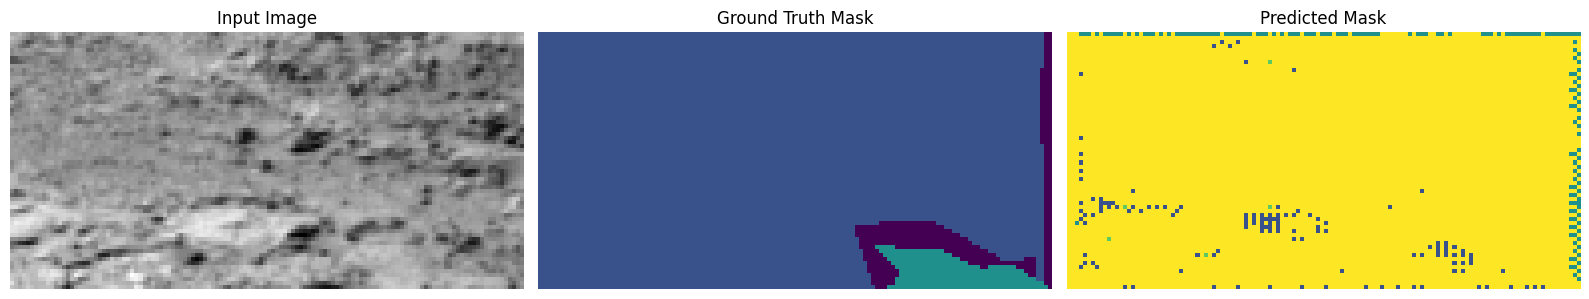

141/141 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - accuracy: 0.2192 - loss: 8.6146 - mean_iou: 0.1323 - val_accuracy: 0.0090 - val_loss: 2.9024 - val_mean_iou: 0.0077 - learning_rate: 1.0000e-04
Epoch 2/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.2070 - loss: 2.5316 - mean_iou: 0.1350 - val_accuracy: 0.2302 - val_loss: 1.8721 - val_mean_iou: 0.1477 - learning_rate: 1.0000e-04
Epoch 3/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.3026 - loss: 1.7970 - mean_iou: 0.2011 - val_accuracy: 0.3198 - val_loss: 1.5922 - val_mean_iou: 0.2416 - learning_rate: 1.0000e-04
Epoch 4/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.3572 - loss: 1.5528 - mean_iou: 0.2531 - val_accuracy: 0.3397 - val_loss: 1.4446 - val_mean_iou: 0.2689 - learning_rate: 1.0000e-04
Epoch 5/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.3695 - loss: 1.4345 - mean_iou: 0.2649 - val_accuracy: 0.3385 - val_loss: 1.3626 - val_mean_iou: 0.2648 - learning_rate: 1.0000e-

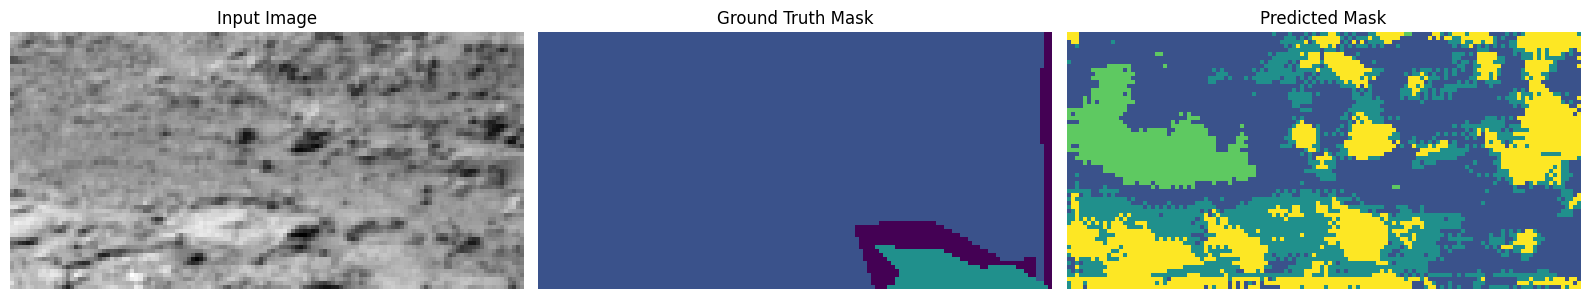

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3806 - loss: 1.3600 - mean_iou: 0.2764 - val_accuracy: 0.3530 - val_loss: 1.3060 - val_mean_iou: 0.2712 - learning_rate: 1.0000e-04
Epoch 7/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.3965 - loss: 1.3125 - mean_iou: 0.2896 - val_accuracy: 0.3692 - val_loss: 1.2661 - val_mean_iou: 0.2840 - learning_rate: 1.0000e-04
Epoch 8/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.4096 - loss: 1.2703 - mean_iou: 0.3012 - val_accuracy: 0.3661 - val_loss: 1.2399 - val_mean_iou: 0.2859 - learning_rate: 1.0000e-04
Epoch 9/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4192 - loss: 1.2371 - mean_iou: 0.3100 - val_accuracy: 0.3508 - val_loss: 1.2254 - val_mean_iou: 0.2736 - learning_rate: 1.0000e-04
Epoch 10/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.4335 - loss: 1.2026 - mean_iou: 0.3258 - val_accuracy: 0.3870 - val_loss: 1.1809 - val_mean_iou: 0.3098 - learning_rate: 1.0000e-

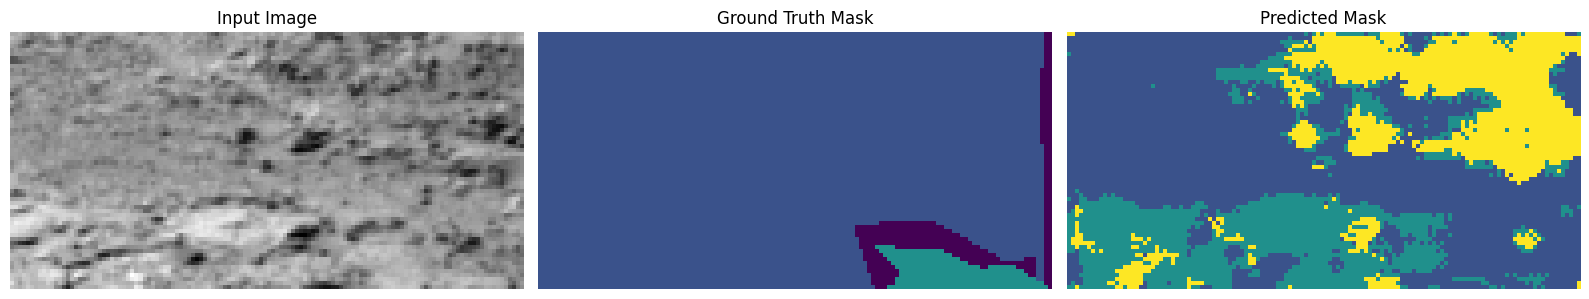

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.4494 - loss: 1.1659 - mean_iou: 0.3428 - val_accuracy: 0.4152 - val_loss: 1.1475 - val_mean_iou: 0.3323 - learning_rate: 1.0000e-04
Epoch 12/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.4717 - loss: 1.1344 - mean_iou: 0.3668 - val_accuracy: 0.4097 - val_loss: 1.1425 - val_mean_iou: 0.3474 - learning_rate: 1.0000e-04
Epoch 13/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4737 - loss: 1.1152 - mean_iou: 0.3736 - val_accuracy: 0.3013 - val_loss: 1.2110 - val_mean_iou: 0.2463 - learning_rate: 1.0000e-04
Epoch 14/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.4526 - loss: 1.1287 - mean_iou: 0.3536 - val_accuracy: 0.4446 - val_loss: 1.0920 - val_mean_iou: 0.3673 - learning_rate: 1.0000e-04
Epoch 15/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5039 - loss: 1.0751 - mean_iou: 0.4026 - val_accuracy: 0.4009 - val_loss: 1.1255 - val_mean_iou: 0.3281 - learning_rate: 1.000

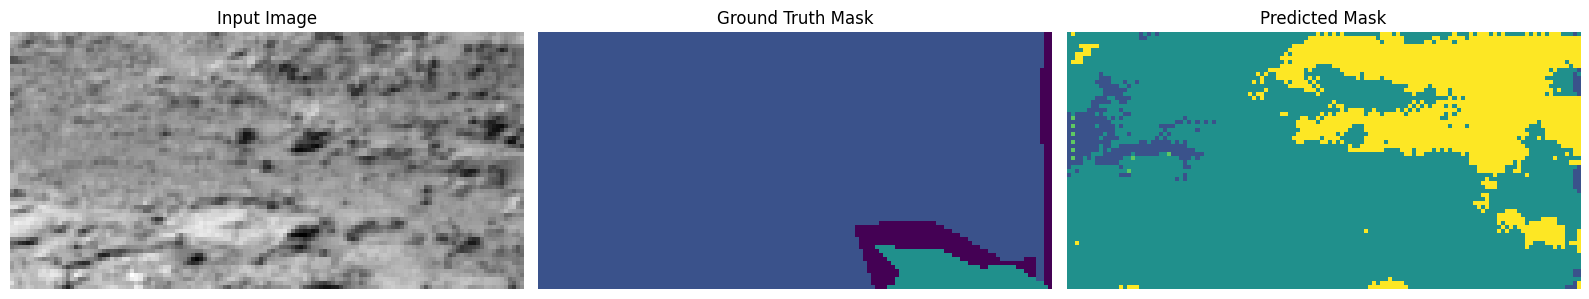

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.5066 - loss: 1.0546 - mean_iou: 0.4050 - val_accuracy: 0.3548 - val_loss: 1.1663 - val_mean_iou: 0.2926 - learning_rate: 1.0000e-04
Epoch 17/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5009 - loss: 1.0589 - mean_iou: 0.4018 - val_accuracy: 0.3756 - val_loss: 1.1286 - val_mean_iou: 0.3159 - learning_rate: 1.0000e-04
Epoch 18/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5061 - loss: 1.0380 - mean_iou: 0.4099 - val_accuracy: 0.4685 - val_loss: 1.0440 - val_mean_iou: 0.3919 - learning_rate: 1.0000e-04
Epoch 19/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5315 - loss: 1.0054 - mean_iou: 0.4331 - val_accuracy: 0.4546 - val_loss: 1.0471 - val_mean_iou: 0.3890 - learning_rate: 1.0000e-04
Epoch 20/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5365 - loss: 0.9939 - mean_iou: 0.4439 - val_accuracy: 0.4747 - val_loss: 1.0185 - val_mean_iou: 0.4050 - learning_rate: 1.000

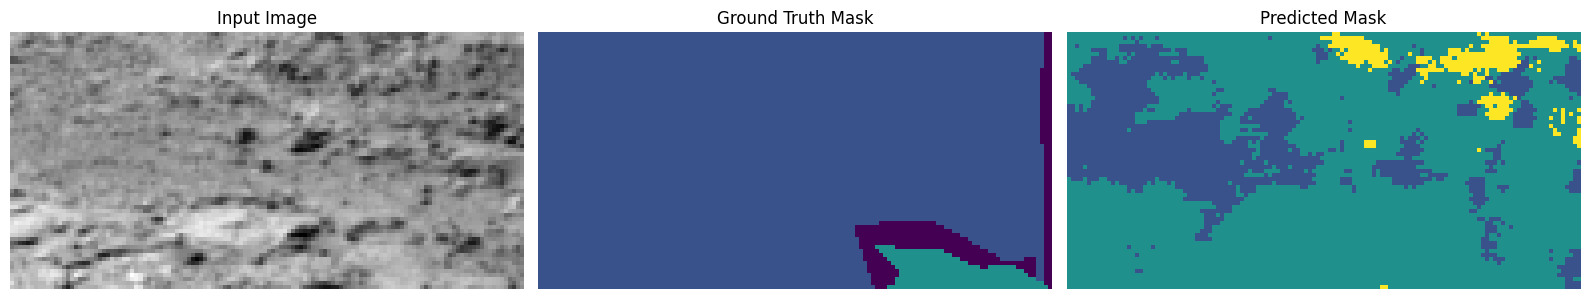

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5384 - loss: 0.9869 - mean_iou: 0.4442 - val_accuracy: 0.5132 - val_loss: 0.9790 - val_mean_iou: 0.4356 - learning_rate: 1.0000e-04
Epoch 22/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5556 - loss: 0.9659 - mean_iou: 0.4628 - val_accuracy: 0.4862 - val_loss: 0.9989 - val_mean_iou: 0.4178 - learning_rate: 1.0000e-04
Epoch 23/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5568 - loss: 0.9672 - mean_iou: 0.4677 - val_accuracy: 0.4879 - val_loss: 0.9839 - val_mean_iou: 0.4225 - learning_rate: 1.0000e-04
Epoch 24/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5414 - loss: 0.9686 - mean_iou: 0.4504 - val_accuracy: 0.5159 - val_loss: 0.9550 - val_mean_iou: 0.4376 - learning_rate: 1.0000e-04
Epoch 25/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5560 - loss: 0.9588 - mean_iou: 0.4624 - val_accuracy: 0.5223 - val_loss: 0.9366 - val_mean_iou: 0.4527 - learning_rate: 1.000

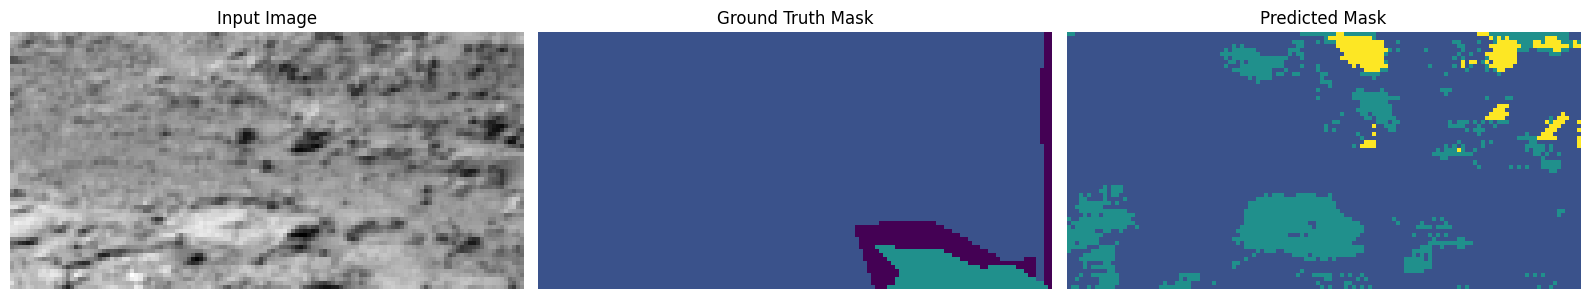

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.5629 - loss: 0.9361 - mean_iou: 0.4761 - val_accuracy: 0.5498 - val_loss: 0.9118 - val_mean_iou: 0.4750 - learning_rate: 1.0000e-04
Epoch 27/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5716 - loss: 0.9189 - mean_iou: 0.4855 - val_accuracy: 0.5329 - val_loss: 0.9179 - val_mean_iou: 0.4606 - learning_rate: 1.0000e-04
Epoch 28/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5717 - loss: 0.9199 - mean_iou: 0.4863 - val_accuracy: 0.5659 - val_loss: 0.8756 - val_mean_iou: 0.4918 - learning_rate: 1.0000e-04
Epoch 29/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5833 - loss: 0.9031 - mean_iou: 0.4997 - val_accuracy: 0.5510 - val_loss: 0.8827 - val_mean_iou: 0.4786 - learning_rate: 1.0000e-04
Epoch 30/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5852 - loss: 0.8905 - mean_iou: 0.5046 - val_accuracy: 0.5467 - val_loss: 0.8872 - val_mean_iou: 0.4811 - learning_rate: 1.000

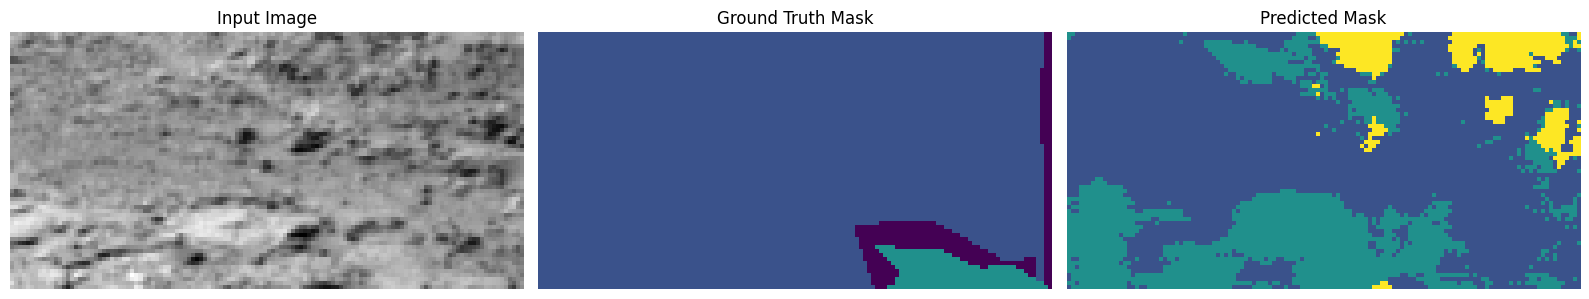

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.5647 - loss: 0.9236 - mean_iou: 0.4782 - val_accuracy: 0.5564 - val_loss: 0.8810 - val_mean_iou: 0.4891 - learning_rate: 1.0000e-04
Epoch 32/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5838 - loss: 0.8815 - mean_iou: 0.5044 - val_accuracy: 0.5634 - val_loss: 0.8615 - val_mean_iou: 0.4916 - learning_rate: 1.0000e-04
Epoch 33/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5932 - loss: 0.8687 - mean_iou: 0.5139 - val_accuracy: 0.5656 - val_loss: 0.8690 - val_mean_iou: 0.5002 - learning_rate: 1.0000e-04
Epoch 34/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5766 - loss: 0.8869 - mean_iou: 0.4938 - val_accuracy: 0.5726 - val_loss: 0.8582 - val_mean_iou: 0.4999 - learning_rate: 1.0000e-04
Epoch 35/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.5766 - loss: 0.8984 - mean_iou: 0.4938 - val_accuracy: 0.4824 - val_loss: 0.9383 - val_mean_iou: 0.4186 - learning_rate: 1.000

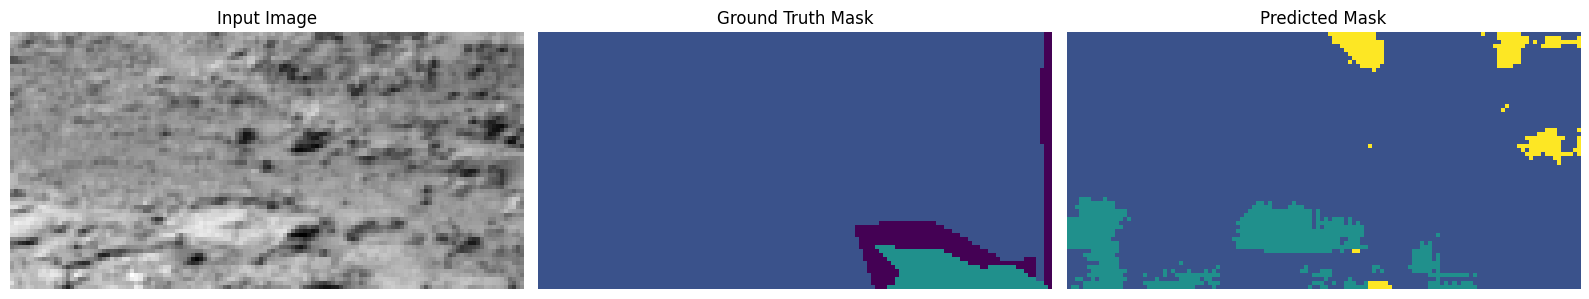

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.5471 - loss: 0.9354 - mean_iou: 0.4616 - val_accuracy: 0.5825 - val_loss: 0.8387 - val_mean_iou: 0.5183 - learning_rate: 1.0000e-04
Epoch 37/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.5967 - loss: 0.8640 - mean_iou: 0.5182 - val_accuracy: 0.5773 - val_loss: 0.8469 - val_mean_iou: 0.5092 - learning_rate: 1.0000e-04
Epoch 38/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.5988 - loss: 0.8584 - mean_iou: 0.5197 - val_accuracy: 0.5708 - val_loss: 0.8399 - val_mean_iou: 0.5098 - learning_rate: 1.0000e-04
Epoch 39/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6017 - loss: 0.8479 - mean_iou: 0.5282 - val_accuracy: 0.5942 - val_loss: 0.8263 - val_mean_iou: 0.5278 - learning_rate: 1.0000e-04
Epoch 40/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6142 - loss: 0.8263 - mean_iou: 0.5427 - val_accuracy: 0.5885 - val_loss: 0.8307 - val_mean_iou: 0.5184 - learning_rate: 1.000

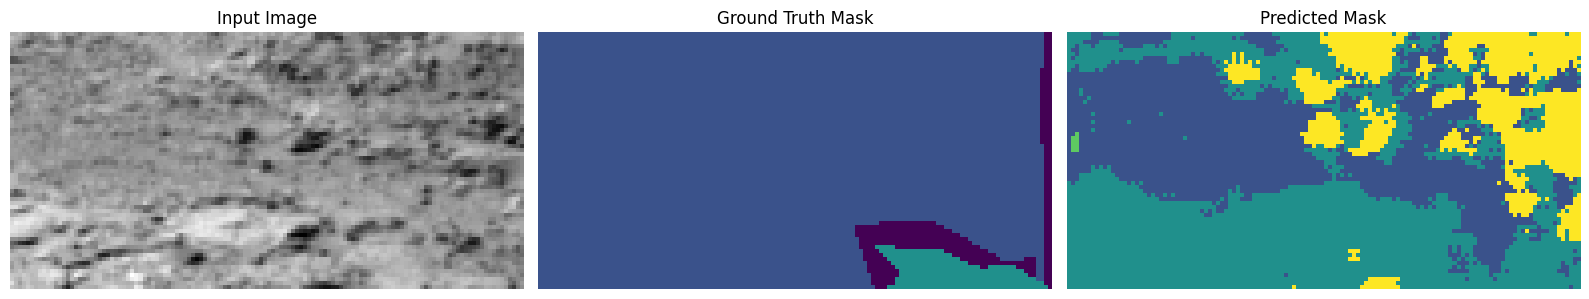

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6148 - loss: 0.8296 - mean_iou: 0.5411 - val_accuracy: 0.5657 - val_loss: 0.8349 - val_mean_iou: 0.5086 - learning_rate: 1.0000e-04
Epoch 42/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6062 - loss: 0.8323 - mean_iou: 0.5348 - val_accuracy: 0.5950 - val_loss: 0.8206 - val_mean_iou: 0.5287 - learning_rate: 1.0000e-04
Epoch 43/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6154 - loss: 0.8168 - mean_iou: 0.5435 - val_accuracy: 0.5985 - val_loss: 0.8152 - val_mean_iou: 0.5277 - learning_rate: 1.0000e-04
Epoch 44/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6209 - loss: 0.8088 - mean_iou: 0.5499 - val_accuracy: 0.6074 - val_loss: 0.7850 - val_mean_iou: 0.5439 - learning_rate: 1.0000e-04
Epoch 45/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6080 - loss: 0.8240 - mean_iou: 0.5315 - val_accuracy: 0.6071 - val_loss: 0.7843 - val_mean_iou: 0.5461 - learning_rate: 1.000

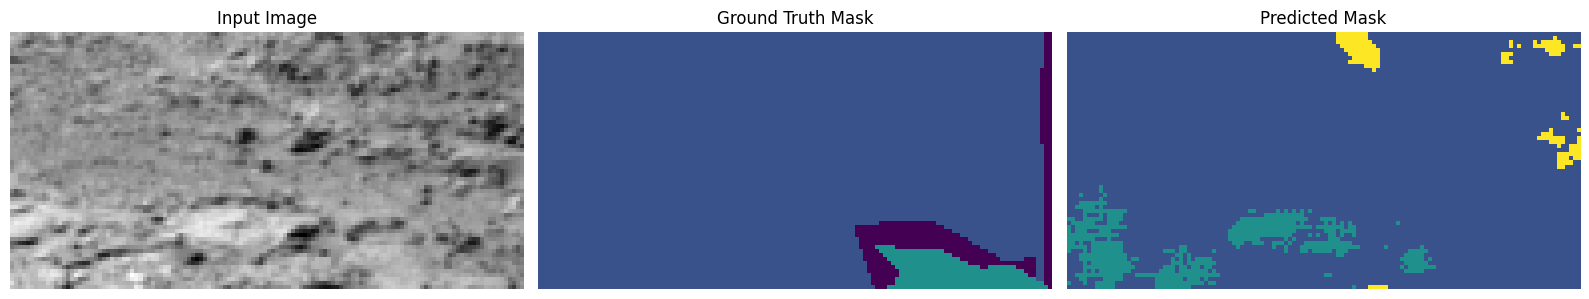

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6232 - loss: 0.8023 - mean_iou: 0.5525 - val_accuracy: 0.6204 - val_loss: 0.7886 - val_mean_iou: 0.5586 - learning_rate: 1.0000e-04
Epoch 47/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6296 - loss: 0.7865 - mean_iou: 0.5614 - val_accuracy: 0.6117 - val_loss: 0.7866 - val_mean_iou: 0.5429 - learning_rate: 1.0000e-04
Epoch 48/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6261 - loss: 0.7955 - mean_iou: 0.5539 - val_accuracy: 0.6074 - val_loss: 0.7828 - val_mean_iou: 0.5452 - learning_rate: 1.0000e-04
Epoch 49/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6252 - loss: 0.7878 - mean_iou: 0.5552 - val_accuracy: 0.5649 - val_loss: 0.8416 - val_mean_iou: 0.4947 - learning_rate: 1.0000e-04
Epoch 50/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6186 - loss: 0.8012 - mean_iou: 0.5495 - val_accuracy: 0.6140 - val_loss: 0.7751 - val_mean_iou: 0.5517 - learning_rate: 1.000

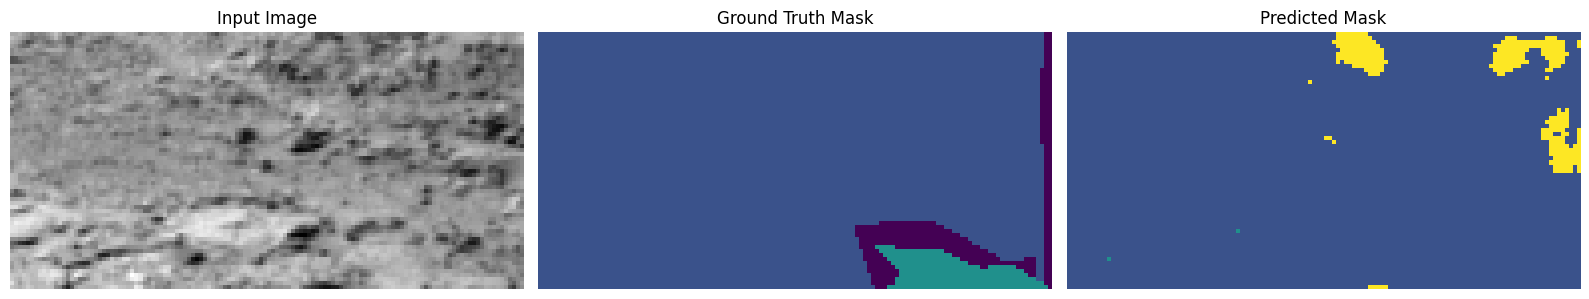

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6303 - loss: 0.7806 - mean_iou: 0.5610 - val_accuracy: 0.6171 - val_loss: 0.7651 - val_mean_iou: 0.5570 - learning_rate: 1.0000e-04
Epoch 52/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6330 - loss: 0.7686 - mean_iou: 0.5671 - val_accuracy: 0.5843 - val_loss: 0.7989 - val_mean_iou: 0.5220 - learning_rate: 1.0000e-04
Epoch 53/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6235 - loss: 0.7808 - mean_iou: 0.5582 - val_accuracy: 0.6172 - val_loss: 0.7669 - val_mean_iou: 0.5555 - learning_rate: 1.0000e-04
Epoch 54/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.6234 - loss: 0.7839 - mean_iou: 0.5515 - val_accuracy: 0.6263 - val_loss: 0.7488 - val_mean_iou: 0.5653 - learning_rate: 1.0000e-04
Epoch 55/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6363 - loss: 0.7652 - mean_iou: 0.5691 - val_accuracy: 0.6278 - val_loss: 0.7381 - val_mean_iou: 0.5698 - learning_rate: 1.000

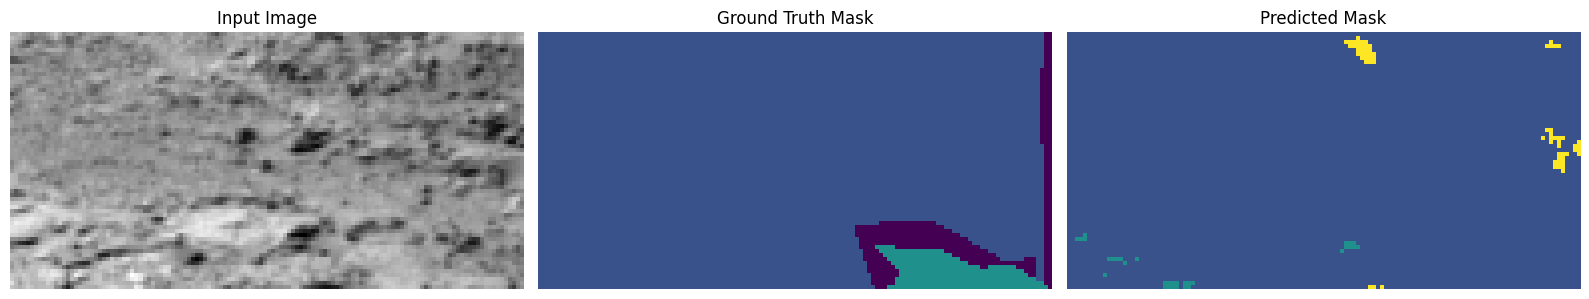

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6384 - loss: 0.7542 - mean_iou: 0.5744 - val_accuracy: 0.6235 - val_loss: 0.7480 - val_mean_iou: 0.5602 - learning_rate: 1.0000e-04
Epoch 57/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6354 - loss: 0.7631 - mean_iou: 0.5676 - val_accuracy: 0.6175 - val_loss: 0.7737 - val_mean_iou: 0.5558 - learning_rate: 1.0000e-04
Epoch 58/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6399 - loss: 0.7578 - mean_iou: 0.5752 - val_accuracy: 0.6136 - val_loss: 0.7585 - val_mean_iou: 0.5467 - learning_rate: 1.0000e-04
Epoch 59/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6462 - loss: 0.7404 - mean_iou: 0.5849 - val_accuracy: 0.6364 - val_loss: 0.7279 - val_mean_iou: 0.5771 - learning_rate: 1.0000e-04
Epoch 60/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6488 - loss: 0.7418 - mean_iou: 0.5883 - val_accuracy: 0.6044 - val_loss: 0.7703 - val_mean_iou: 0.5461 - learning_rate: 1.000

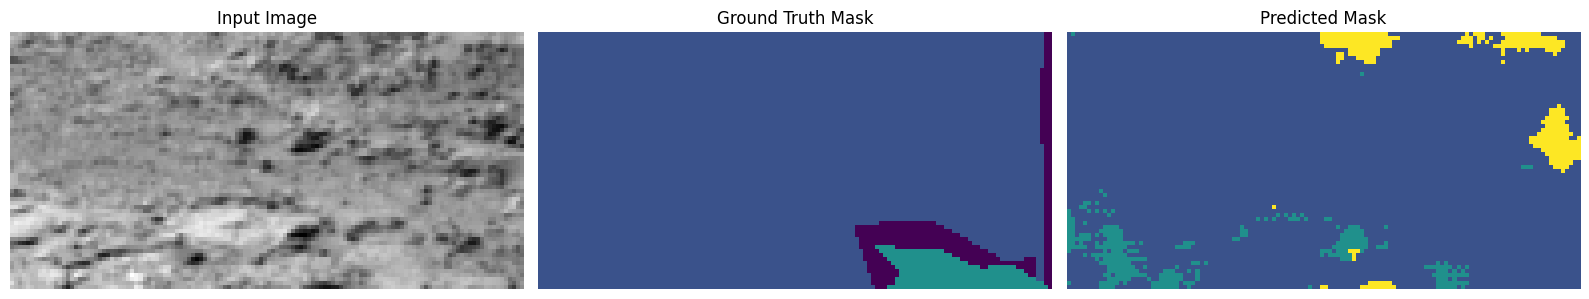

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6355 - loss: 0.7537 - mean_iou: 0.5694 - val_accuracy: 0.6272 - val_loss: 0.7625 - val_mean_iou: 0.5684 - learning_rate: 1.0000e-04
Epoch 62/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6500 - loss: 0.7394 - mean_iou: 0.5903 - val_accuracy: 0.6205 - val_loss: 0.7510 - val_mean_iou: 0.5593 - learning_rate: 1.0000e-04
Epoch 63/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6492 - loss: 0.7295 - mean_iou: 0.5904 - val_accuracy: 0.6188 - val_loss: 0.7454 - val_mean_iou: 0.5589 - learning_rate: 1.0000e-04
Epoch 64/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6453 - loss: 0.7387 - mean_iou: 0.5845 - val_accuracy: 0.6004 - val_loss: 0.7450 - val_mean_iou: 0.5442 - learning_rate: 1.0000e-04
Epoch 65/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6400 - loss: 0.7520 - mean_iou: 0.5757 - val_accuracy: 0.6160 - val_loss: 0.7487 - val_mean_iou: 0.5591 - learning_rate: 1.000

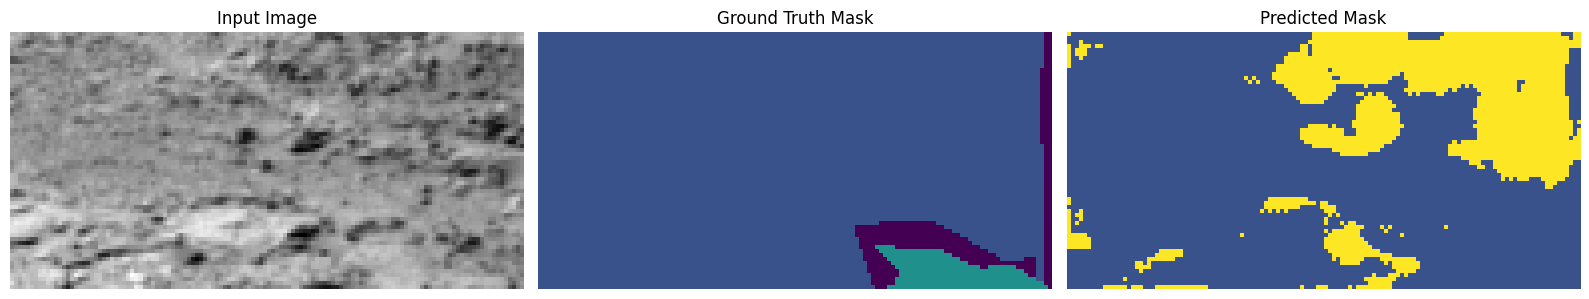

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6473 - loss: 0.7306 - mean_iou: 0.5883 - val_accuracy: 0.5534 - val_loss: 0.8595 - val_mean_iou: 0.4972 - learning_rate: 1.0000e-04
Epoch 67/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6203 - loss: 0.7723 - mean_iou: 0.5633 - val_accuracy: 0.6375 - val_loss: 0.7464 - val_mean_iou: 0.5766 - learning_rate: 1.0000e-04
Epoch 68/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6552 - loss: 0.7200 - mean_iou: 0.5978 - val_accuracy: 0.6034 - val_loss: 0.7715 - val_mean_iou: 0.5441 - learning_rate: 1.0000e-04
Epoch 69/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6449 - loss: 0.7298 - mean_iou: 0.5832 - val_accuracy: 0.6243 - val_loss: 0.7342 - val_mean_iou: 0.5654 - learning_rate: 1.0000e-04
Epoch 70/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6562 - loss: 0.7122 - mean_iou: 0.6007 - val_accuracy: 0.6252 - val_loss: 0.7389 - val_mean_iou: 0.5711 - learning_rate: 1.000

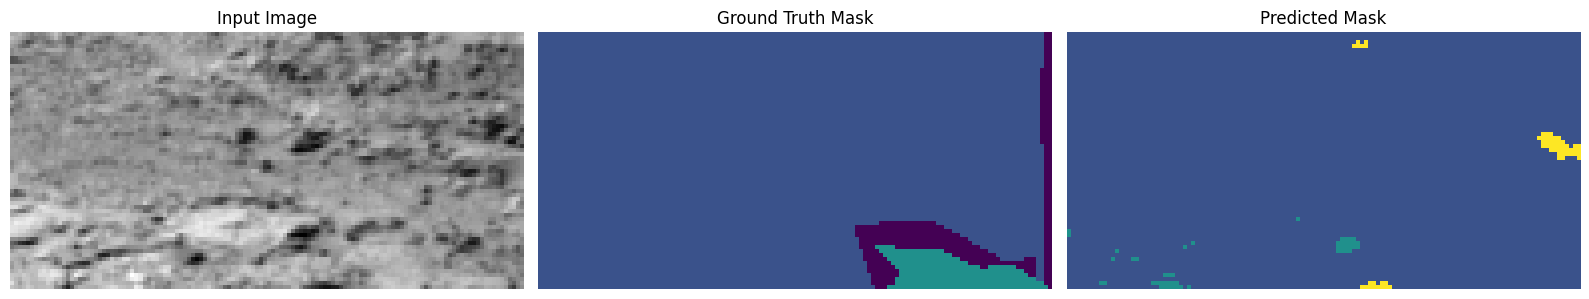

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6557 - loss: 0.7077 - mean_iou: 0.6020 - val_accuracy: 0.6426 - val_loss: 0.7372 - val_mean_iou: 0.5835 - learning_rate: 1.0000e-04
Epoch 72/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6532 - loss: 0.7190 - mean_iou: 0.5950 - val_accuracy: 0.6453 - val_loss: 0.7045 - val_mean_iou: 0.5910 - learning_rate: 1.0000e-04
Epoch 73/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6617 - loss: 0.6952 - mean_iou: 0.6094 - val_accuracy: 0.6139 - val_loss: 0.7454 - val_mean_iou: 0.5492 - learning_rate: 1.0000e-04
Epoch 74/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6415 - loss: 0.7257 - mean_iou: 0.5814 - val_accuracy: 0.6413 - val_loss: 0.7284 - val_mean_iou: 0.5832 - learning_rate: 1.0000e-04
Epoch 75/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6651 - loss: 0.6918 - mean_iou: 0.6137 - val_accuracy: 0.5758 - val_loss: 0.9209 - val_mean_iou: 0.4907 - learning_rate: 1.000

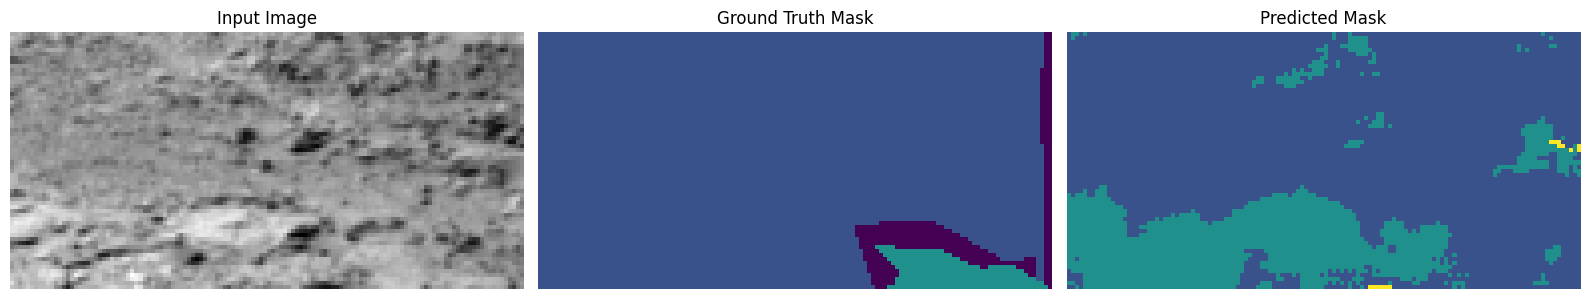

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6469 - loss: 0.7209 - mean_iou: 0.5925 - val_accuracy: 0.6435 - val_loss: 0.7618 - val_mean_iou: 0.5831 - learning_rate: 1.0000e-04
Epoch 77/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6547 - loss: 0.7096 - mean_iou: 0.5971 - val_accuracy: 0.6446 - val_loss: 0.7428 - val_mean_iou: 0.5823 - learning_rate: 1.0000e-04
Epoch 78/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6530 - loss: 0.7112 - mean_iou: 0.5935 - val_accuracy: 0.6443 - val_loss: 0.7090 - val_mean_iou: 0.5873 - learning_rate: 1.0000e-04
Epoch 79/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6575 - loss: 0.7101 - mean_iou: 0.6018 - val_accuracy: 0.6367 - val_loss: 0.7524 - val_mean_iou: 0.5794 - learning_rate: 1.0000e-04
Epoch 80/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6669 - loss: 0.6864 - mean_iou: 0.6175 - val_accuracy: 0.5968 - val_loss: 0.8060 - val_mean_iou: 0.5391 - learning_rate: 1.000

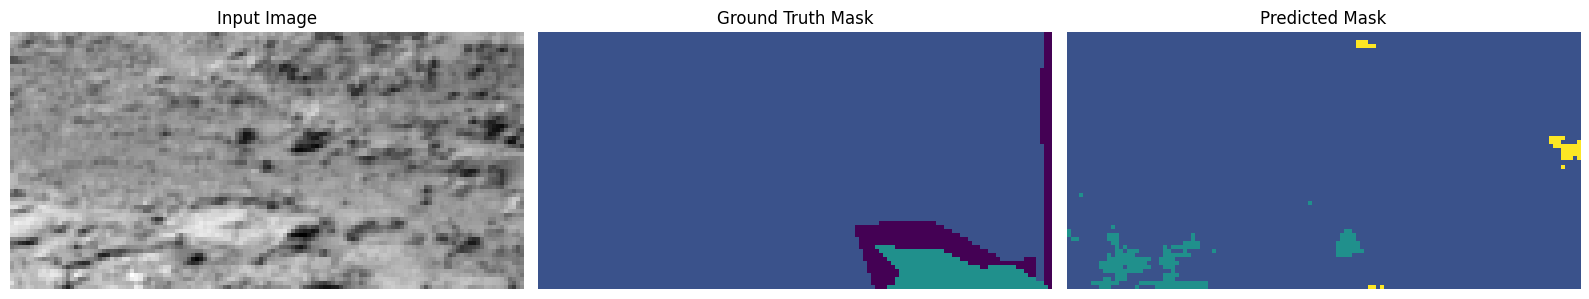

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.6422 - loss: 0.7557 - mean_iou: 0.5788 - val_accuracy: 0.6308 - val_loss: 0.7238 - val_mean_iou: 0.5781 - learning_rate: 1.0000e-04
Epoch 82/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6640 - loss: 0.6887 - mean_iou: 0.6131 - val_accuracy: 0.6434 - val_loss: 0.7219 - val_mean_iou: 0.5886 - learning_rate: 1.0000e-04
Epoch 83/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6672 - loss: 0.6809 - mean_iou: 0.6164 - val_accuracy: 0.6267 - val_loss: 0.7246 - val_mean_iou: 0.5658 - learning_rate: 1.0000e-04
Epoch 84/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6605 - loss: 0.6857 - mean_iou: 0.6092 - val_accuracy: 0.6332 - val_loss: 0.7108 - val_mean_iou: 0.5771 - learning_rate: 1.0000e-04
Epoch 85/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6488 - loss: 0.7085 - mean_iou: 0.5886 - val_accuracy: 0.6494 - val_loss: 0.7103 - val_mean_iou: 0.5942 - learning_rate: 1.000

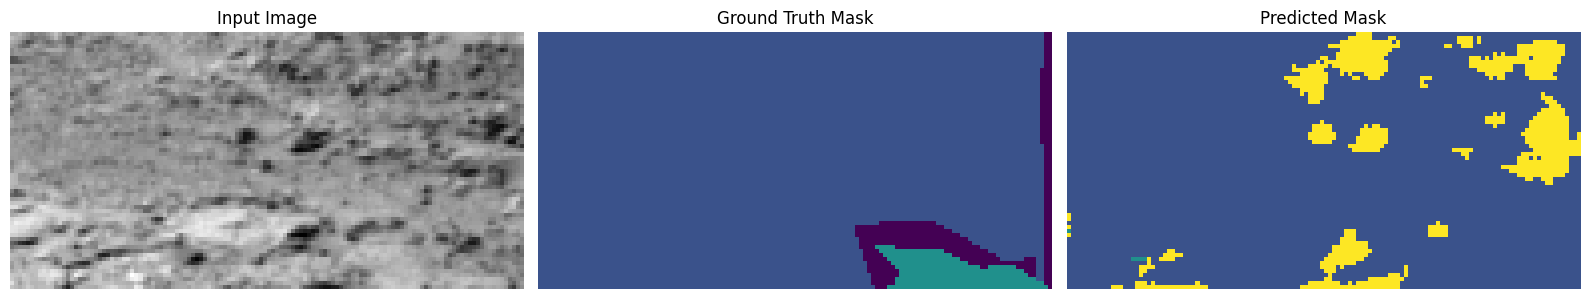

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6716 - loss: 0.6746 - mean_iou: 0.6241 - val_accuracy: 0.6176 - val_loss: 0.7605 - val_mean_iou: 0.5624 - learning_rate: 1.0000e-04
Epoch 87/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6609 - loss: 0.6815 - mean_iou: 0.6127 - val_accuracy: 0.6333 - val_loss: 0.7596 - val_mean_iou: 0.5674 - learning_rate: 1.0000e-04
Epoch 88/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6718 - loss: 0.6703 - mean_iou: 0.6236 - val_accuracy: 0.6573 - val_loss: 0.7421 - val_mean_iou: 0.5942 - learning_rate: 1.0000e-05
Epoch 89/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6834 - loss: 0.6420 - mean_iou: 0.6432 - val_accuracy: 0.6592 - val_loss: 0.7411 - val_mean_iou: 0.5999 - learning_rate: 1.0000e-05
Epoch 90/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6857 - loss: 0.6334 - mean_iou: 0.6475 - val_accuracy: 0.6568 - val_loss: 0.7504 - val_mean_iou: 0.5951 - learning_rate: 1.000

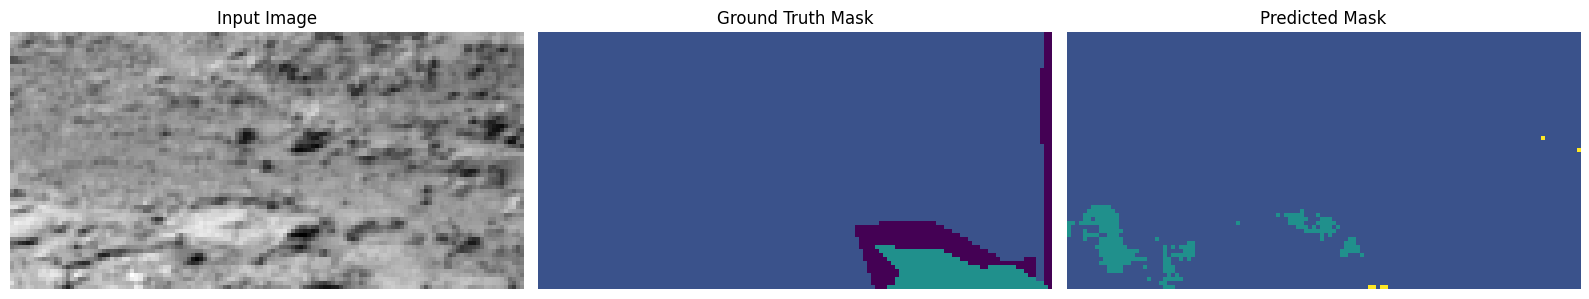

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.6884 - loss: 0.6322 - mean_iou: 0.6517 - val_accuracy: 0.6611 - val_loss: 0.7308 - val_mean_iou: 0.6031 - learning_rate: 1.0000e-05
Epoch 92/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6896 - loss: 0.6280 - mean_iou: 0.6541 - val_accuracy: 0.6628 - val_loss: 0.7369 - val_mean_iou: 0.6045 - learning_rate: 1.0000e-05
Epoch 93/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6903 - loss: 0.6254 - mean_iou: 0.6555 - val_accuracy: 0.6600 - val_loss: 0.7339 - val_mean_iou: 0.6013 - learning_rate: 1.0000e-05
Epoch 94/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6912 - loss: 0.6240 - mean_iou: 0.6575 - val_accuracy: 0.6633 - val_loss: 0.7303 - val_mean_iou: 0.6049 - learning_rate: 1.0000e-05
Epoch 95/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6918 - loss: 0.6229 - mean_iou: 0.6582 - val_accuracy: 0.6631 - val_loss: 0.7378 - val_mean_iou: 0.6049 - learning_rate: 1.000

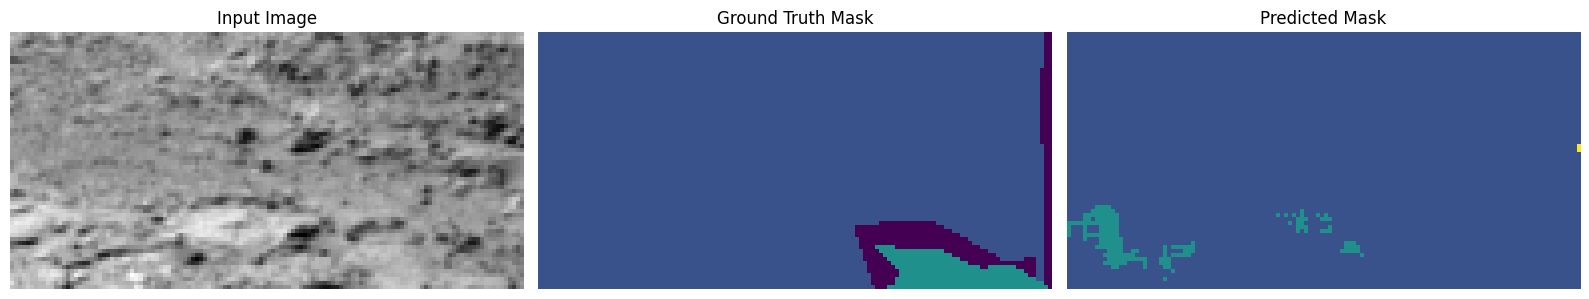

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.6908 - loss: 0.6241 - mean_iou: 0.6564 - val_accuracy: 0.6602 - val_loss: 0.7398 - val_mean_iou: 0.6010 - learning_rate: 1.0000e-05
Epoch 97/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6925 - loss: 0.6204 - mean_iou: 0.6598 - val_accuracy: 0.6655 - val_loss: 0.7358 - val_mean_iou: 0.6079 - learning_rate: 1.0000e-05
Epoch 98/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6947 - loss: 0.6146 - mean_iou: 0.6639 - val_accuracy: 0.6591 - val_loss: 0.7374 - val_mean_iou: 0.6000 - learning_rate: 1.0000e-05
Epoch 99/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6950 - loss: 0.6136 - mean_iou: 0.6642 - val_accuracy: 0.6635 - val_loss: 0.7416 - val_mean_iou: 0.6048 - learning_rate: 1.0000e-05
Epoch 100/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6904 - loss: 0.6222 - mean_iou: 0.6564 - val_accuracy: 0.6562 - val_loss: 0.7399 - val_mean_iou: 0.5964 - learning_rate: 1.00

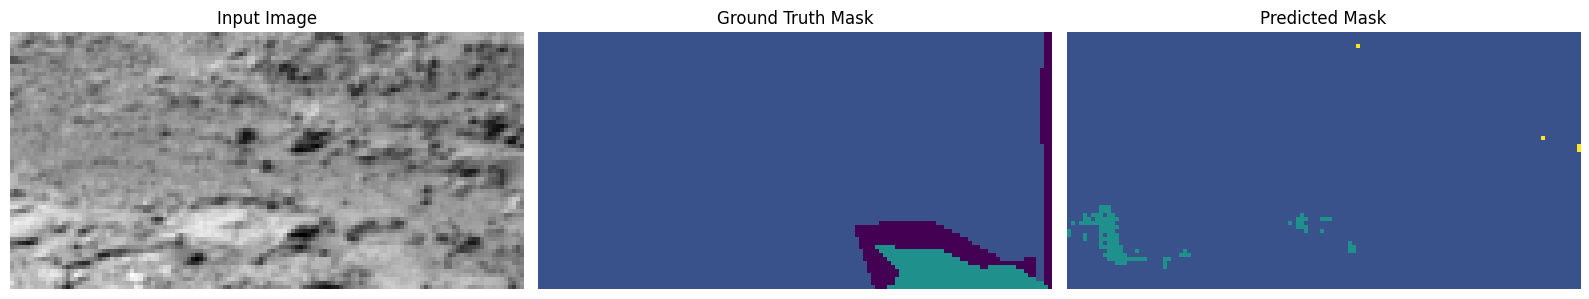

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6948 - loss: 0.6130 - mean_iou: 0.6632 - val_accuracy: 0.6606 - val_loss: 0.7483 - val_mean_iou: 0.6011 - learning_rate: 1.0000e-05
Epoch 102/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6929 - loss: 0.6152 - mean_iou: 0.6609 - val_accuracy: 0.6629 - val_loss: 0.7395 - val_mean_iou: 0.6051 - learning_rate: 1.0000e-05
Epoch 103/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6949 - loss: 0.6095 - mean_iou: 0.6636 - val_accuracy: 0.6671 - val_loss: 0.7455 - val_mean_iou: 0.6101 - learning_rate: 1.0000e-06
Epoch 104/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6988 - loss: 0.6061 - mean_iou: 0.6711 - val_accuracy: 0.6679 - val_loss: 0.7509 - val_mean_iou: 0.6105 - learning_rate: 1.0000e-06
Epoch 105/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6980 - loss: 0.6087 - mean_iou: 0.6697 - val_accuracy: 0.6678 - val_loss: 0.7522 - val_mean_iou: 0.6101 - learning_rate: 1

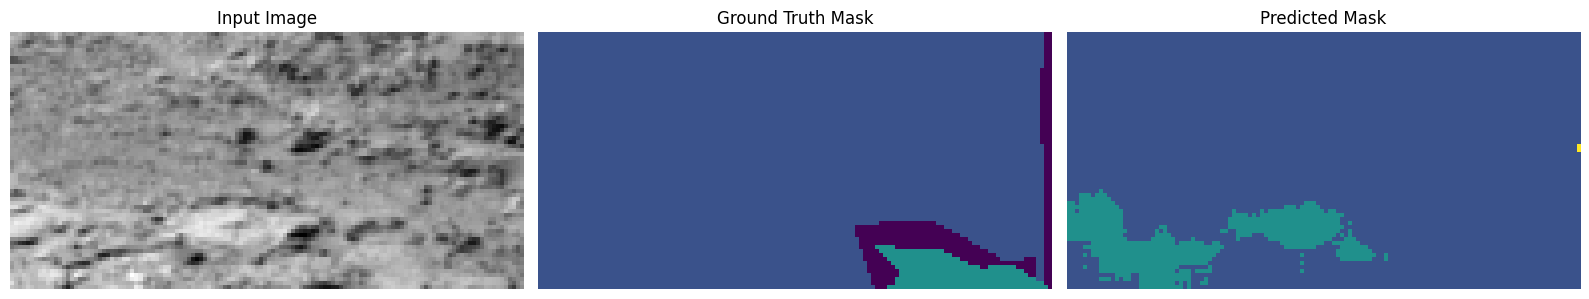

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.6979 - loss: 0.6095 - mean_iou: 0.6698 - val_accuracy: 0.6681 - val_loss: 0.7505 - val_mean_iou: 0.6107 - learning_rate: 1.0000e-06
Epoch 107/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6995 - loss: 0.6056 - mean_iou: 0.6731 - val_accuracy: 0.6682 - val_loss: 0.7525 - val_mean_iou: 0.6105 - learning_rate: 1.0000e-06
Epoch 108/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6987 - loss: 0.6068 - mean_iou: 0.6716 - val_accuracy: 0.6681 - val_loss: 0.7538 - val_mean_iou: 0.6103 - learning_rate: 1.0000e-06
Epoch 109/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6997 - loss: 0.6055 - mean_iou: 0.6744 - val_accuracy: 0.6684 - val_loss: 0.7529 - val_mean_iou: 0.6108 - learning_rate: 1.0000e-06
Epoch 110/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6980 - loss: 0.6084 - mean_iou: 0.6702 - val_accuracy: 0.6684 - val_loss: 0.7516 - val_mean_iou: 0.6108 - learning_rate: 1

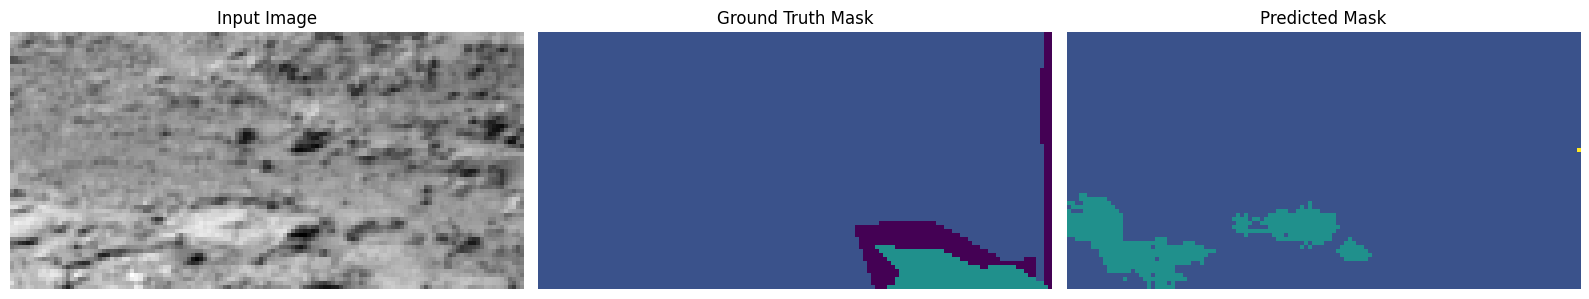

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7012 - loss: 0.6025 - mean_iou: 0.6770 - val_accuracy: 0.6679 - val_loss: 0.7512 - val_mean_iou: 0.6102 - learning_rate: 1.0000e-06
Epoch 112/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7013 - loss: 0.6048 - mean_iou: 0.6765 - val_accuracy: 0.6675 - val_loss: 0.7512 - val_mean_iou: 0.6097 - learning_rate: 1.0000e-06
Epoch 113/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7009 - loss: 0.6016 - mean_iou: 0.6758 - val_accuracy: 0.6675 - val_loss: 0.7536 - val_mean_iou: 0.6096 - learning_rate: 1.0000e-06
Epoch 114/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7013 - loss: 0.6035 - mean_iou: 0.6764 - val_accuracy: 0.6671 - val_loss: 0.7541 - val_mean_iou: 0.6090 - learning_rate: 1.0000e-06
Epoch 115/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6994 - loss: 0.6047 - mean_iou: 0.6734 - val_accuracy: 0.6675 - val_loss: 0.7560 - val_mean_iou: 0.6093 - learning_rate: 1

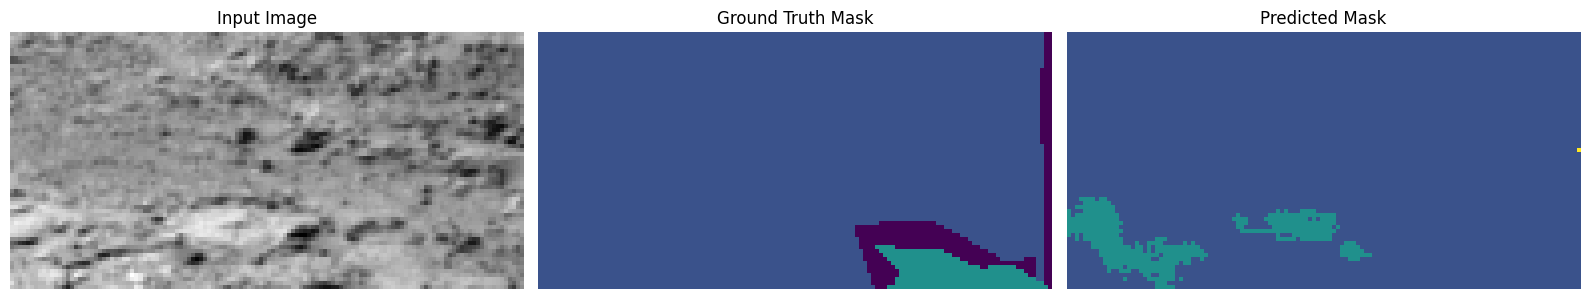

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7013 - loss: 0.6024 - mean_iou: 0.6768 - val_accuracy: 0.6671 - val_loss: 0.7577 - val_mean_iou: 0.6088 - learning_rate: 1.0000e-06
Epoch 117/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7015 - loss: 0.6027 - mean_iou: 0.6769 - val_accuracy: 0.6677 - val_loss: 0.7575 - val_mean_iou: 0.6095 - learning_rate: 1.0000e-06
Epoch 118/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7008 - loss: 0.6033 - mean_iou: 0.6762 - val_accuracy: 0.6677 - val_loss: 0.7572 - val_mean_iou: 0.6095 - learning_rate: 1.0000e-07
Epoch 119/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7010 - loss: 0.6032 - mean_iou: 0.6764 - val_accuracy: 0.6676 - val_loss: 0.7568 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-07
Epoch 120/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7014 - loss: 0.6017 - mean_iou: 0.6774 - val_accuracy: 0.6675 - val_loss: 0.7568 - val_mean_iou: 0.6093 - learning_rate: 1

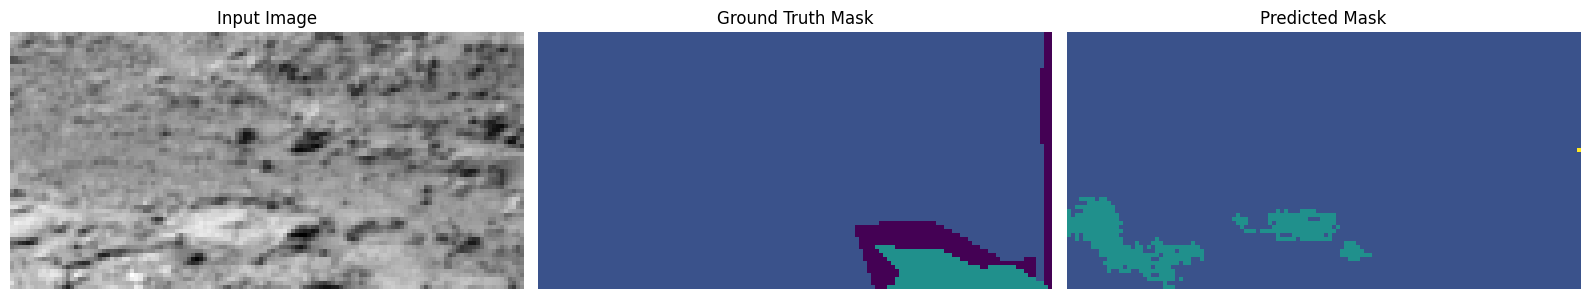

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.7018 - loss: 0.6016 - mean_iou: 0.6780 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 122/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7011 - loss: 0.6017 - mean_iou: 0.6763 - val_accuracy: 0.6674 - val_loss: 0.7566 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 123/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7015 - loss: 0.6053 - mean_iou: 0.6778 - val_accuracy: 0.6674 - val_loss: 0.7567 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 124/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7033 - loss: 0.5992 - mean_iou: 0.6803 - val_accuracy: 0.6674 - val_loss: 0.7567 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 125/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7014 - loss: 0.6044 - mean_iou: 0.6768 - val_accuracy: 0.6674 - val_loss: 0.7569 - val_mean_iou: 0.6092 - learning_rate: 1

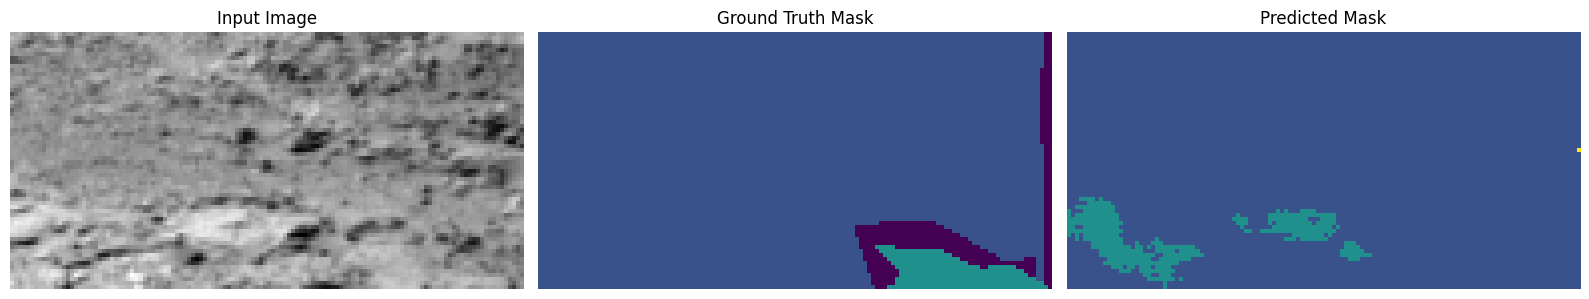

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7019 - loss: 0.6002 - mean_iou: 0.6779 - val_accuracy: 0.6674 - val_loss: 0.7567 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 127/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7020 - loss: 0.6003 - mean_iou: 0.6779 - val_accuracy: 0.6674 - val_loss: 0.7567 - val_mean_iou: 0.6093 - learning_rate: 1.0000e-07
Epoch 128/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7013 - loss: 0.6039 - mean_iou: 0.6765 - val_accuracy: 0.6675 - val_loss: 0.7563 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-07
Epoch 129/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7010 - loss: 0.6012 - mean_iou: 0.6766 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-07
Epoch 130/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7012 - loss: 0.6027 - mean_iou: 0.6765 - val_accuracy: 0.6675 - val_loss: 0.7567 - val_mean_iou: 0.6095 - learning_rate: 1

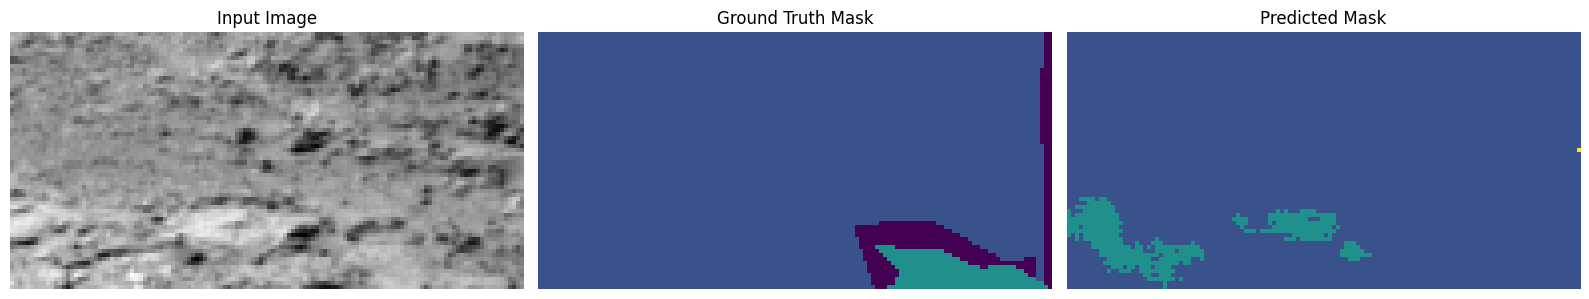

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7011 - loss: 0.6019 - mean_iou: 0.6770 - val_accuracy: 0.6675 - val_loss: 0.7564 - val_mean_iou: 0.6095 - learning_rate: 1.0000e-07
Epoch 132/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7014 - loss: 0.6014 - mean_iou: 0.6772 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-07
Epoch 133/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7029 - loss: 0.6026 - mean_iou: 0.6800 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 134/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6972 - loss: 0.6068 - mean_iou: 0.6694 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 135/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7022 - loss: 0.6009 - mean_iou: 0.6787 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1

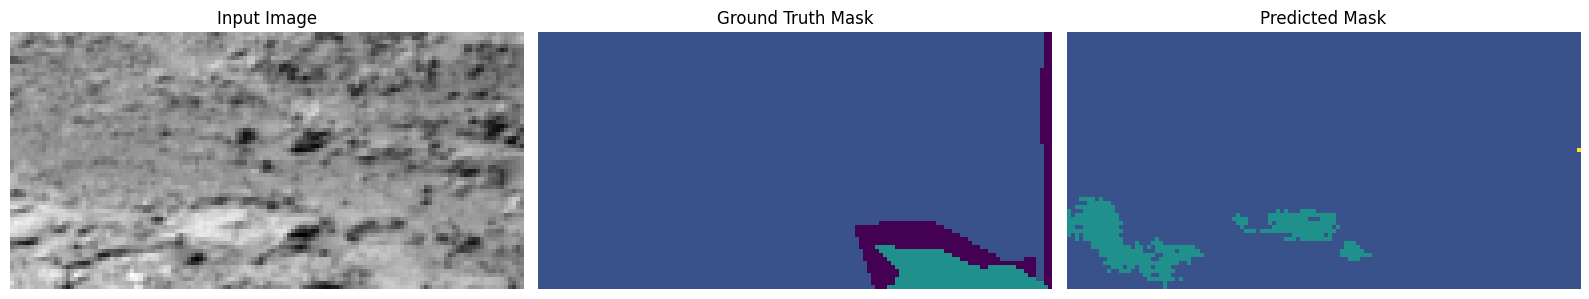

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.7018 - loss: 0.6019 - mean_iou: 0.6778 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 137/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7028 - loss: 0.6014 - mean_iou: 0.6794 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 138/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7024 - loss: 0.6013 - mean_iou: 0.6787 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 139/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7026 - loss: 0.6013 - mean_iou: 0.6792 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 140/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7008 - loss: 0.6012 - mean_iou: 0.6764 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1

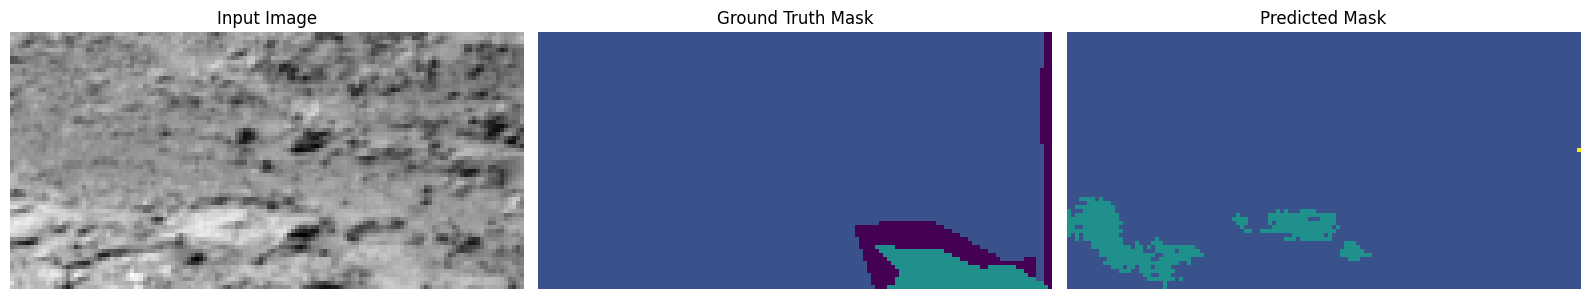

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.6980 - loss: 0.6050 - mean_iou: 0.6709 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 142/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7011 - loss: 0.6013 - mean_iou: 0.6764 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 143/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7003 - loss: 0.6028 - mean_iou: 0.6754 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 144/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7014 - loss: 0.6016 - mean_iou: 0.6773 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 145/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7018 - loss: 0.6002 - mean_iou: 0.6778 - val_accuracy: 0.6674 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1

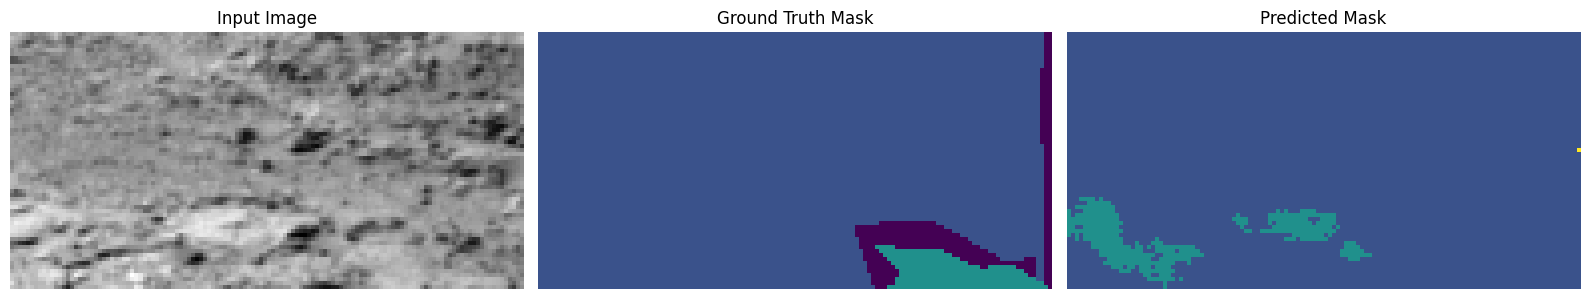

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.7023 - loss: 0.6024 - mean_iou: 0.6784 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 147/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7021 - loss: 0.5996 - mean_iou: 0.6783 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 148/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7032 - loss: 0.6004 - mean_iou: 0.6801 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 149/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.6992 - loss: 0.6040 - mean_iou: 0.6733 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 150/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.6994 - loss: 0.6064 - mean_iou: 0.6735 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1

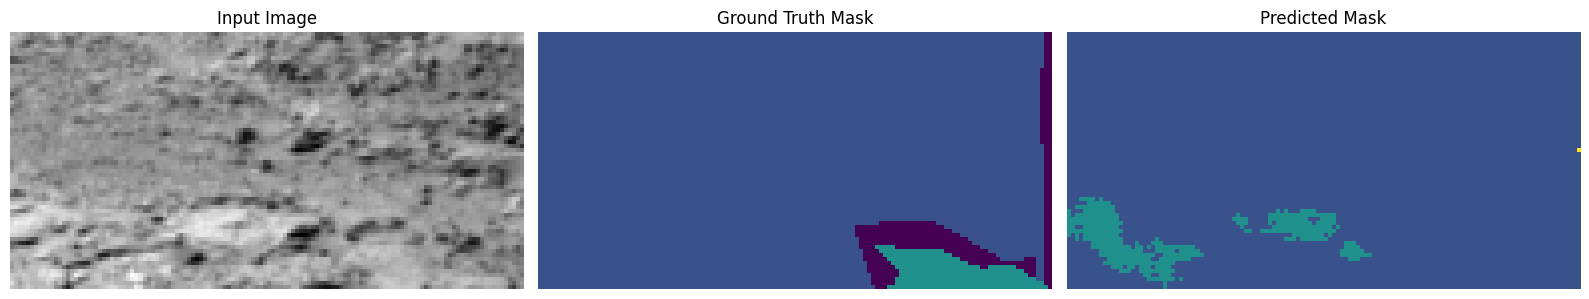

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.7022 - loss: 0.6008 - mean_iou: 0.6786 - val_accuracy: 0.6675 - val_loss: 0.7565 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 152/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7028 - loss: 0.6009 - mean_iou: 0.6797 - val_accuracy: 0.6675 - val_loss: 0.7566 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 153/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7026 - loss: 0.6013 - mean_iou: 0.6789 - val_accuracy: 0.6675 - val_loss: 0.7566 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 154/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7005 - loss: 0.6034 - mean_iou: 0.6756 - val_accuracy: 0.6674 - val_loss: 0.7566 - val_mean_iou: 0.6094 - learning_rate: 1.0000e-08
Epoch 155/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.7005 - loss: 0.6024 - mean_iou: 0.6753 - val_accuracy: 0.6674 - val_loss: 0.7566 - val_mean_iou: 0.6094 - learning_rate: 1

In [32]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")

In [33]:
# Save the model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_160152.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [34]:
# Load the model
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_160152.keras


In [35]:
# Predict
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step
Predictions shape: (10022, 64, 128)


In [36]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 912ms/step
Accuracy score over the test set: 0.6684


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score over the test set: 0.5356
Recall score over the test set: 0.6684
F1 score over the test set: 0.5927


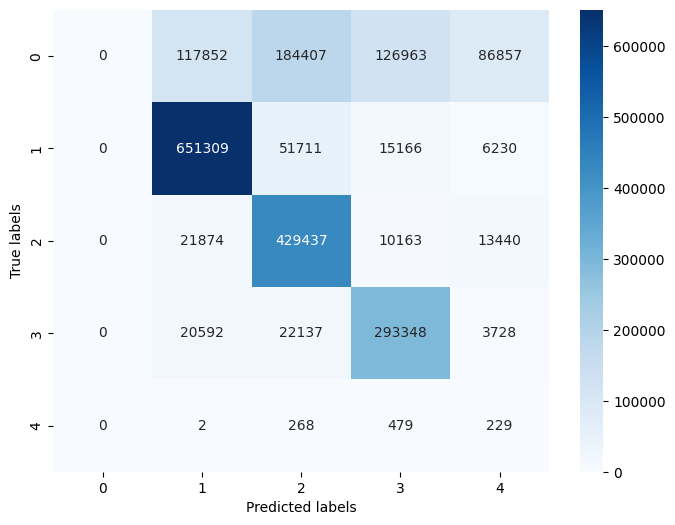

In [38]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

# Predict class probabilities and get predicted classes on the validation set.
test_predictions = np.argmax(model.predict(X_val), axis=-1).flatten()

# Extract ground truth classes.
test_gt = y_val.flatten()

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision.
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall.
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
    cmap="Blues",
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

The results are good for classes 1 to 3, while the model has issues recognizing class 4. Class 0 is never predicted, as the loss function only penalizes misclassifications of class 0 indirectly.